In [954]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [955]:
from google.colab import drive, files
drive.mount('/content/drive')
rootpath = '/content/drive/Shareddrives/KW phase1 repo'
import sys
sys.path.append(rootpath+'/package')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [956]:
import cvxpy as cp
from utils.env import env
from model.pureSDP import SDP
from model.pathlossmodel import PathLossModel, NoiseMaker
from service.measurerss import measureRSS

In [957]:
div = 100
pick = 3
model="VAE"
dataFolder = "/0810_v2"

### Read final anomaly detection results

In [958]:
import pickle as dill
_UAVsSamples = {}
iSample = 0
with open(rootpath+"/datas/anomalyNewSDPResult"+dataFolder+"/UAVsSamples_pick{}div{}_300.npy".format(pick,div), 'rb') as f:
  while True:
    if iSample >= env.LOAD_SAMPLES_FOR_AE:
       break
    try:
      _UAVsSamples[iSample] = dill.load(f)
      iSample += 1
    except EOFError:
      break
UAVsSamples = _UAVsSamples
print(UAVsSamples)

{0: {0: <model.uav.UAV object at 0x7f6c16ba3fd0>, 1: <model.uav.UAV object at 0x7f6c16ba3f50>, 2: <model.uav.UAV object at 0x7f6c16ba3810>, 3: <model.uav.UAV object at 0x7f6c16ba3b10>, 4: <model.uav.UAV object at 0x7f6c16ba3490>, 5: <model.uav.UAV object at 0x7f6c16ba3550>, 6: <model.uav.UAV object at 0x7f6c16ba3d10>, 7: <model.uav.UAV object at 0x7f6c16ba3250>, 8: <model.uav.UAV object at 0x7f6c16ba3390>, 9: <model.uav.UAV object at 0x7f6c16ba3050>, 10: <model.uav.UAV object at 0x7f6c16ba3510>, 11: <model.uav.UAV object at 0x7f6c16ba3090>, 12: <model.uav.UAV object at 0x7f6c16ba3c50>, 13: <model.uav.UAV object at 0x7f6c16ba3c10>, 14: <model.uav.UAV object at 0x7f6c1816db50>, 15: <model.uav.UAV object at 0x7f6c1884bd90>}, 1: {0: <model.uav.UAV object at 0x7f6c16ba3f90>, 1: <model.uav.UAV object at 0x7f6c16335a10>, 2: <model.uav.UAV object at 0x7f6c16335fd0>, 3: <model.uav.UAV object at 0x7f6c16335790>, 4: <model.uav.UAV object at 0x7f6c16335d50>, 5: <model.uav.UAV object at 0x7f6c16335

In [959]:
pathLossModel = PathLossModel()
pathLossModel.noiseMaker = NoiseMaker(mean = env.noiseMean, deviation = env.noiseDeviation)

In [960]:
Samples = len(UAVsSamples)
print("Samples : ", Samples)

Samples :  100


In [961]:
OriginAnchors = {}
OriginTargets = {}
for iSample in UAVsSamples:
  originAnchorsOfSample = []
  originTargetsOfSample = []
  for iUAVOfSample in UAVsSamples[iSample]:
    if UAVsSamples[iSample][iUAVOfSample].observedPosition == None:
      originTargetsOfSample.append(UAVsSamples[iSample][iUAVOfSample])
    else:
      originAnchorsOfSample.append(UAVsSamples[iSample][iUAVOfSample])
  OriginAnchors[iSample] = originAnchorsOfSample
  OriginTargets[iSample] = originTargetsOfSample

In [962]:
anomalyUAVsSample = {}
for iSample in UAVsSamples:
  anomalyUAV = []
  for IDOfUAV in UAVsSamples[iSample]:
    uav = UAVsSamples[iSample][IDOfUAV]
    if not uav.observedPosition == None:
      if not uav.observedPosition == uav.realPosition:
        anomalyUAV.append(IDOfUAV)
  anomalyUAVsSample[iSample] = anomalyUAV
anomalyUAVs = [anomalyUAVsSample]

In [963]:
OriginAnchors = OriginAnchors
OriginTargets = OriginTargets

In [964]:
import pickle
f = open(rootpath+"/datas/datas_forAnomalyDetection/BestAnchorsSDP/0808_3_100sample_{}anomaly_{}div_SelectedAnchors_{}.pkl".format(pick,div,model), "rb")
goodUAVsSample = pickle.load(f)
f.close()

In [965]:
for uavId,uav in UAVsSamples[1].items():
  print(uav.id,uav.observedPosition,uav.realPosition)
print(goodUAVsSample[1])

0 None [397.0, 984.0, 377.0]
1 None [198.0, 195.0, 783.0]
2 None [0.0, 892.0, 546.0]
3 [395.0, 269.0, 367.0] [395.0, 269.0, 367.0]
4 [932.0, 762.0, 731.0] [932.0, 762.0, 731.0]
5 None [165.0, 560.0, 663.0]
6 [1408.0, 1297.0, 1468.0] [327.0, 256.0, 228.0]
7 None [238.0, 438.0, 318.0]
8 [1969.0, 1310.0, 1533.0] [700.0, 115.0, 393.0]
9 [127.0, 383.0, 164.0] [127.0, 383.0, 164.0]
10 None [606.0, 780.0, 529.0]
11 [263.0, 387.0, 922.0] [263.0, 387.0, 922.0]
12 None [64.0, 24.0, 376.0]
13 [824.0, 220.0, 366.0] [824.0, 220.0, 366.0]
14 None [701.0, 233.0, 110.0]
15 [1515.0, 1924.0, 1405.0] [185.0, 749.0, 405.0]
[6, 15, 11, 3, 13, 9, 4, 8]


In [966]:
SelectedAnchors = {}
SelectedTargets = {}
for iSample in goodUAVsSample:
  selectedAnchorsOfSample = []
  selectedTargetsOfSample = []
  for IDOfUAV in UAVsSamples[iSample]:
    if IDOfUAV in goodUAVsSample[iSample]:
      selectedAnchorsOfSample.append(UAVsSamples[iSample][IDOfUAV])
    else:
      selectedTargetsOfSample.append(UAVsSamples[iSample][IDOfUAV])
  SelectedAnchors[iSample] = selectedAnchorsOfSample
  SelectedTargets[iSample] = selectedTargetsOfSample

In [967]:
SelectedAnchors = SelectedAnchors
SelectedTargets = SelectedTargets

### Calculate SOC-SDP

In [968]:
EstimatedPositionBeforeAnomalyDetection = {}
for Sample in range(Samples):
  print("#{:3d}".format(Sample))
  sdp = SDP()
  sdp.var_SOCPt = cp.Variable(1)
  sdp.var_SDPt = cp.Variable(1)
  sdp.var_p = [cp.Variable((env.DIMENSION+1, env.DIMENSION+1), symmetric=True) for i in range(len(OriginTargets[Sample]))]
  
  sdp.buildConstraint(OriginTargets[Sample], OriginAnchors[Sample], pathLossModel)
  sdp.doSolve(log=False)
  targetPositions = [sdp.var_p[i].value[-1][:3] for i in range(len(OriginTargets[Sample]))]
  EstimatedPositionBeforeAnomalyDetection[Sample] = targetPositions

#  0
#  1
#  2
#  3
#  4
#  5
#  6
#  7
#  8
#  9
# 10
# 11
# 12
# 13
# 14
# 15
# 16
# 17
# 18
# 19
# 20
# 21
# 22
# 23
# 24
# 25
# 26
# 27
# 28
# 29
# 30
# 31
# 32
# 33
# 34
# 35
# 36
# 37
# 38
# 39
# 40
# 41
# 42
# 43
# 44
# 45
# 46
# 47
# 48
# 49
# 50
# 51
# 52
# 53
# 54
# 55
# 56
# 57
# 58
# 59
# 60
# 61
# 62
# 63
# 64
# 65
# 66
# 67
# 68
# 69
# 70
# 71
# 72
# 73
# 74
# 75
# 76
# 77
# 78
# 79
# 80
# 81
# 82
# 83
# 84
# 85
# 86
# 87
# 88
# 89
# 90
# 91
# 92
# 93
# 94
# 95
# 96
# 97
# 98
# 99


In [969]:
EstimatedPositionAfterAnomalyDetection = {}
for Sample in range(Samples):
  print("#{:3d}".format(Sample))
  sdp = SDP()
  sdp.var_SOCPt = cp.Variable(1)
  sdp.var_SDPt = cp.Variable(1)
  sdp.var_p = [cp.Variable((env.DIMENSION+1, env.DIMENSION+1), symmetric=True) for i in range(len(SelectedTargets[Sample]))]
  
  if not len(SelectedAnchors[Sample]) == 0:
    sdp.buildConstraint(SelectedTargets[Sample], SelectedAnchors[Sample], pathLossModel)
    sdp.doSolve(log=False)
    targetPositions = [sdp.var_p[i].value[-1][:3] for i in range(len(SelectedTargets[Sample]))]
    EstimatedPositionAfterAnomalyDetection[Sample] = targetPositions

#  0
#  1
#  2
#  3
#  4
#  5
#  6
#  7
#  8
#  9
# 10
# 11
# 12
# 13
# 14
# 15
# 16
# 17
# 18
# 19
# 20
# 21
# 22
# 23
# 24
# 25
# 26
# 27
# 28
# 29
# 30
# 31
# 32
# 33
# 34
# 35
# 36
# 37
# 38
# 39
# 40
# 41
# 42
# 43
# 44
# 45
# 46
# 47
# 48
# 49
# 50
# 51
# 52
# 53
# 54
# 55
# 56
# 57
# 58
# 59
# 60
# 61
# 62
# 63
# 64
# 65
# 66
# 67
# 68
# 69
# 70
# 71
# 72
# 73
# 74
# 75
# 76
# 77
# 78
# 79
# 80
# 81
# 82
# 83
# 84
# 85
# 86
# 87
# 88
# 89
# 90
# 91
# 92
# 93
# 94
# 95
# 96
# 97
# 98
# 99


### Plot SOC-SDP result and localization RMSE

In [970]:
import datetime, os
now = datetime.datetime.now()
month = '{:02d}'.format(now.month)
day = '{:02d}'.format(now.day)

In [971]:
# import matplotlib.pyplot as plt

# fig = plt.figure(figsize=(12,12))
# ax = plt.axes(projection='3d')
# ax.set_xlim([0, 1300])
# ax.set_ylim([0, 1300])
# ax.set_zlim([0, 1300])
# ax.set_xlabel('x-axis (m)', fontsize=18)
# ax.set_ylabel('y-axis (m)', fontsize=18)
# ax.set_zlabel('z-axis (m)', fontsize=18)
# plt.grid()

# scatters = []
# scattersLegends = []

# sample = 1

# for originAnchor in OriginAnchors[sample]:
#   p = originAnchor.realPosition
#   if originAnchor.realPosition == originAnchor.observedPosition:
#     scatter1 = ax.scatter(p[0], p[1], p[2], c='#FF0000', marker='*', s=64, alpha=1)
#   else:
#     scatter_anomaly = ax.scatter(p[0], p[1], p[2], c='#000000', marker='^', s=64, alpha=1)
#     scatter_anomalyPosition = ax.scatter(originAnchor.observedPosition[0], originAnchor.observedPosition[1], originAnchor.observedPosition[2], c='#000000', marker='^', s=64, alpha=0.5)
# scatters.append(scatter1)
# scattersLegends.append("Origin Anchor UAVs")
# scatters.append(scatter_anomaly)
# scattersLegends.append("Anomaly Anchor UAVs (True Position)")
# scatters.append(scatter_anomalyPosition)
# scattersLegends.append("Anomaly Anchor UAVs (Wrong Position)")

# for originTarget in OriginTargets[sample]:
#   p = originTarget.realPosition
#   scatter2 = ax.scatter(p[0], p[1], p[2], c='#0000FF', marker='x', s=64, alpha=1)
# scatters.append(scatter2)
# scattersLegends.append("Target UAVs (without GPS)")

# for i, estimatedPosition in enumerate(EstimatedPositionBeforeAnomalyDetection[sample]):
#   p = estimatedPosition
#   scatter3 = ax.scatter(p[0], p[1], p[2], c='#00FF00', marker='o', s=64, alpha=1)
# scatters.append(scatter3)
# scattersLegends.append("Estimated Positions of Target UAVs")

# plt.legend(scatters, scattersLegends, loc='upper right', shadow=True)
# # plt.savefig(rootpath+'/datas/localizationResult/beforeDetection{}_{}_{}.svg'.format(div, pick, model))

In [972]:
# import matplotlib.pyplot as plt

# fig = plt.figure(figsize=(12,12))
# ax = plt.axes(projection='3d')
# ax.set_xlim([0, 1300])
# ax.set_ylim([0, 1300])
# ax.set_zlim([0, 1300])
# ax.set_xlabel('x-axis (m)', fontsize=18)
# ax.set_ylabel('y-axis (m)', fontsize=18)
# ax.set_zlabel('z-axis (m)', fontsize=18)
# plt.grid()

# scatters = []
# scattersLegends = []

# sample = 1

# for originAnchor in SelectedAnchors[sample]:
#   p = originAnchor.realPosition
#   if originAnchor.realPosition == originAnchor.observedPosition:
#     scatter1 = ax.scatter(p[0], p[1], p[2], c='#FF0000', marker='*', s=64, alpha=1)
#   else:
#     scatter_anomaly = ax.scatter(p[0], p[1], p[2], c='#000000', marker='^', s=64, alpha=1)
#     scatters.append(scatter_anomaly)
#     scattersLegends.append("Anomaly Anchor UAVs")
# scatters.append(scatter1)
# scattersLegends.append("Selected Anchor UAVs")

# for originTarget in SelectedTargets[sample]:
#   p = originTarget.realPosition
#   if originTarget.observedPosition == None:
#     scatter2 = ax.scatter(p[0], p[1], p[2], c='#0000FF', marker='x', s=64, alpha=1)
#   else:
#     scatter_anomaly = ax.scatter(p[0], p[1], p[2], c='#000000', marker='x', s=64, alpha=1)
#     scatters.append(scatter_anomaly)
#     scattersLegends.append("Target UAVs (with Anomalous GPS)")
# scatters.append(scatter2)
# scattersLegends.append("Target UAVs (without GPS)")

# for i, estimatedPosition in enumerate(EstimatedPositionAfterAnomalyDetection[sample]):
#   p_bar = SelectedTargets[sample][i].realPosition
#   p = estimatedPosition
#   # plt.plot([p_bar[0], p[0]], [p_bar[1], p[1]], [p_bar[2], p[2]], c='#000000', linewidth=3.0)
#   scatter3 = ax.scatter(p[0], p[1], p[2], c='#00FF00', marker='o', s=64, alpha=1)
# scatters.append(scatter3)
# scattersLegends.append("Estimated Positions of Target UAVs")

# plt.legend(scatters, scattersLegends, loc='upper right', shadow=True)
# # plt.savefig(rootpath+'/datas/localizationResult/afterDetection{}_{}_{}.svg'.format(div, pick, model))

In [973]:
import numpy as np
MSE = lambda x,y: np.mean(np.square(np.array(x)-np.array(y)))

In [974]:
Before_Total_sumMSE = []
Before_Total_sumRMSE = []
Before_Each_sumMSE = []
Before_Each_sumRMSE = []
for Sample in range(Samples):
  origin_Nngps = len(OriginTargets[Sample])
  origin_Ngps = len(OriginAnchors[Sample])
  sumMSE = []
  sumRMSE = []
  for i in range(origin_Nngps):
    trueP = OriginTargets[Sample][i].realPosition
    estimatedP = EstimatedPositionBeforeAnomalyDetection[Sample][i]
    mse = MSE(trueP, estimatedP)
    rmse = np.sqrt(mse)
    # print("Targets: ", trueP, estimatedP, mse, rmse)
    sumMSE.append(mse)
    sumRMSE.append(rmse)
  for i in range(origin_Ngps):
    trueP = OriginAnchors[Sample][i].realPosition
    estimatedP = OriginAnchors[Sample][i].observedPosition
    if not trueP == estimatedP:
      mse = MSE(trueP, estimatedP)
      rmse = np.sqrt(mse)
      # print("Anchors: ", trueP, estimatedP, mse, rmse)
      sumMSE.append(mse)
      sumRMSE.append(rmse)
  Before_Total_sumMSE.append(sum(sumMSE))
  Before_Each_sumMSE.append(sumMSE)
  Before_Total_sumRMSE.append(sum(sumRMSE))
  Before_Each_sumRMSE.append(sumRMSE)

avg_sumMSE = np.mean(Before_Total_sumMSE)/env.N
avg_sumRMSE = np.mean(Before_Total_sumRMSE)/env.N
print("Average MSE: {}, RMSE: {}.".format(avg_sumMSE, avg_sumRMSE))

import os
try:
  os.makedirs(rootpath+'/datas/localizationResult')
except OSError as error:
  print(error)

# np.save(rootpath+'/datas/localizationResult/before_localization_avgMSE{}_{}_{}'.format(div, pick, model), avg_sumMSE)
# np.save(rootpath+'/datas/localizationResult/before_localization_avgRMSE{}_{}_{}'.format(div, pick, model), avg_sumRMSE)
f = open(rootpath+'/datas/localizationResultSDP/0808_3_before_localization_avgRMSE{}_{}_{}_v2.pkl'.format(div, pick, model), "wb")
pickle.dump(avg_sumRMSE, f)
f.close()

# np.save(rootpath+'/datas/localizationResult/before_localization_MSE{}_{}_{}'.format(div, pick, model), Before_Each_sumMSE)
# np.save(rootpath+'/datas/localizationResult/before_localization_RMSE{}_{}_{}'.format(div, pick, model), Before_Each_sumRMSE)

# f = open(rootpath+'/datas/localizationResult/before_localization_MSE{}_{}_{}.pkl'.format(div, pick, model), "wb")
# pickle.dump(Before_Each_sumMSE, f)
# f.close()

f = open(rootpath+'/datas/localizationResultSDP/0808_3_before_localization_RMSE{}_{}_{}_v2.pkl'.format(div, pick, model), "wb")
pickle.dump(Before_Each_sumRMSE, f)
f.close()

Average MSE: 638619.77014624, RMSE: 628.8774978800952.
[Errno 17] File exists: '/content/drive/Shareddrives/KW phase1 repo/datas/localizationResult'


[[573.1035253655534, 293.48635879185565, 546.0096937745864, 516.1325221159229, 757.5595642254235, 1020.7383474432153, 740.1142224613557, 500.17097847344183, 1172.7815937618848, 1189.1894998975843, 1179.7533640553859], [461.2388972517099, 609.24563121887, 652.2856126211593, 623.7633950882151, 688.4065653938507, 544.6064564873028, 935.170239843992, 948.4632262814381, 1123.9575911335207, 1202.4954608368937, 1176.08460580011], [786.0521309842493, 823.9493464317176, 734.851170507042, 826.7724951768474, 943.7045681466642, 719.8257853339087, 769.6530690904384, 1294.0022125646267, 1177.1588677829343, 1146.909325099417, 1133.273870989121], [729.8364577053622, 540.2147019548768, 1025.9011947722363, 521.3902436131276, 621.7143169552868, 1400.5141446294717, 909.5451724099905, 552.6837202494875, 1233.6302795678562, 1136.7651472489822, 1180.7688173389404], [1051.820515431113, 940.3860256816926, 539.6472481076974, 696.0868824494058, 1269.9360805063814, 939.2168854526058, 527.6947319665336, 832.477310

Text(0.5, 0, 'Localization Error')

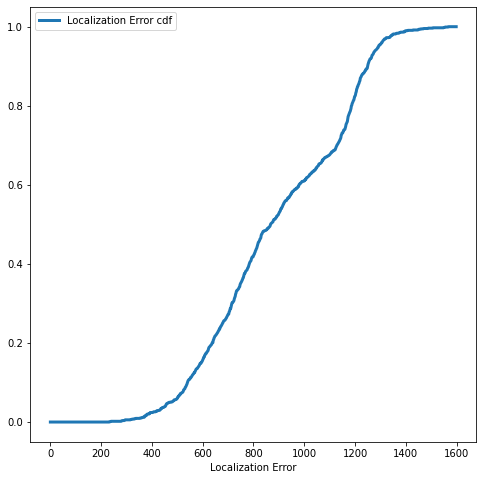

In [975]:
print(Before_Each_sumRMSE)
# print(np.array(Before_Each_sumMSE).flatten().tolist())
Before_sumRMSE = np.concatenate(([], np.array(Before_Each_sumRMSE).flatten().tolist()),axis=0)
# Before_sumRMSE = [np.log(y) for y in Before_sumRMSE]
print(Before_sumRMSE)
Before_RMSEHist, Before_bin_edges = np.histogram(Before_sumRMSE, bins=1000, range=(0, 1.6*1e3), density=True)
normalizeBefore_RMSEHist = Before_RMSEHist*np.diff(Before_bin_edges)

Before_cdf=np.cumsum(normalizeBefore_RMSEHist)

import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(1,1, figsize = (8,8))
ax1.plot(Before_bin_edges[:-1], Before_cdf, label = 'Localization Error cdf', linewidth=3.0)
# ax1.hist(Before_sumMSE, bins = 1000, label = 'Localization Error cdf', range=(0, 1.0*1e6), alpha = 0.5, cumulative=True, density=True)
ax1.legend()
ax1.set_xlabel('Localization Error')

In [976]:
After_Total_sumMSE = []
After_Total_sumRMSE = []
After_Each_sumMSE = []
After_Each_sumRMSE = []
for Sample in range(Samples):
  new_Nngps = len(SelectedTargets[Sample])
  new_Ngps = len(SelectedAnchors[Sample])
  sumMSE = []
  sumRMSE = []
  for i in range(new_Nngps):
    trueP = SelectedTargets[Sample][i].realPosition
    try:
      estimatedP = EstimatedPositionAfterAnomalyDetection[Sample][i]
    except:
      pass
    mse = MSE(trueP, estimatedP)
    rmse = np.sqrt(mse)
    # print("Targets: ", trueP, estimatedP, mse, rmse)
    sumMSE.append(mse)
    sumRMSE.append(rmse)
  for i in range(new_Ngps):
    trueP = SelectedAnchors[Sample][i].realPosition
    estimatedP = SelectedAnchors[Sample][i].observedPosition
    if not trueP == estimatedP:
      mse = MSE(trueP, estimatedP)
      rmse = np.sqrt(mse)
      # print("Anchors: ", trueP, estimatedP, mse, rmse)
      sumMSE.append(mse)
      sumRMSE.append(rmse)
  After_Total_sumMSE.append(sum(sumMSE))
  After_Each_sumMSE.append(sumMSE)
  After_Total_sumRMSE.append(sum(sumRMSE))
  After_Each_sumRMSE.append(sumRMSE)

avg_sumMSE = np.mean(After_Total_sumMSE)/env.N
avg_sumRMSE = np.mean(After_Total_sumRMSE)/env.N
print("Average MSE: {}, RMSE: {}.".format(avg_sumMSE, avg_sumRMSE))

try:
  os.makedirs(rootpath+'/datas/localizationResultSDP')
except OSError as error:
  print(error)


# np.save(rootpath+'/datas/localizationResult/after_localization_MSE{}_{}_{}'.format(div, pick, model), avg_sumMSE)
# np.save(rootpath+'/datas/localizationResult/after_localization_avgRMSE{}_{}_{}'.format(div, pick, model), avg_sumRMSE)
f = open(rootpath+'/datas/localizationResultSDP/0808_3_after_localization_avgRMSE{}_{}_{}_v2.pkl'.format(div, pick, model), "wb")
pickle.dump(avg_sumRMSE, f)
f.close()

# np.save(rootpath+'/datas/localizationResult/after_localization_MSE{}_{}_{}'.format(div, pick, model), After_Each_sumMSE)
# np.save(rootpath+'/datas/localizationResult/after_localization_RMSE{}_{}_{}'.format(div, pick, model), After_Each_sumRMSE)

# f = open(rootpath+'/datas/localizationResult/after_localization_MSE{}_{}_{}.pkl'.format(div, pick, model), "wb")
# pickle.dump(After_Each_sumMSE, f)
# f.close()

f = open(rootpath+'/datas/localizationResultSDP/0808_3_after_localization_RMSE{}_{}_{}_v2.pkl'.format(div, pick, model), "wb")
pickle.dump(After_Each_sumRMSE, f)
f.close()

Average MSE: 649854.843286411, RMSE: 637.371951458764.
[Errno 17] File exists: '/content/drive/Shareddrives/KW phase1 repo/datas/localizationResultSDP'


[[573.1035253655534, 293.48635879185565, 546.0096937745864, 516.1325221159229, 757.5595642254235, 1020.7383474432153, 740.1142224613557, 500.17097847344183, 1172.7815937618848, 1189.1894998975843, 1179.7533640553859], [461.2388972517099, 609.24563121887, 652.2856126211593, 623.7633950882151, 688.4065653938507, 544.6064564873028, 935.170239843992, 948.4632262814381, 1123.9575911335207, 1202.4954608368937, 1176.08460580011], [786.0521309842493, 823.9493464317176, 734.851170507042, 826.7724951768474, 943.7045681466642, 719.8257853339087, 769.6530690904384, 1294.0022125646267, 1177.1588677829343, 1146.909325099417, 1133.273870989121], [729.8364577053622, 540.2147019548768, 1025.9011947722363, 521.3902436131276, 621.7143169552868, 1400.5141446294717, 909.5451724099905, 552.6837202494875, 1233.6302795678562, 1136.7651472489822, 1180.7688173389404], [1051.820515431113, 940.3860256816926, 539.6472481076974, 696.0868824494058, 1269.9360805063814, 939.2168854526058, 527.6947319665336, 832.477310

Text(0.5, 0, 'Localization Error')

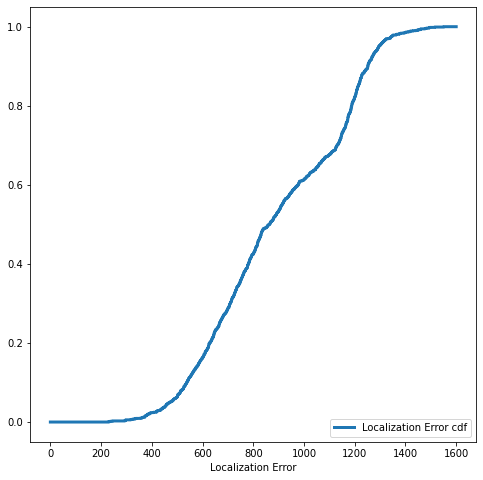

In [977]:
# After_Each_sumRMSE = np.load(rootpath+'/datas/localizationResult/after_localization_RMSE{}_{}_{}.npy'.format(div, pick, model), allow_pickle=True)
print(After_Each_sumRMSE)
from functools import reduce
from operator import add
After_sumRMSE = reduce(add ,After_Each_sumRMSE)
# print(np.array(After_Each_sumMSE).reshape(-1))
# After_sumMSE = np.concatenate(([], np.array(After_Each_sumMSE).flatten().tolist()),axis=0)
# After_sumRMSE = [np.log(y) for y in After_sumRMSE]
print(After_sumRMSE)
After_RMSEHist, After_bin_edges = np.histogram(After_sumRMSE, bins=50000, range=(0, 1.6*1e3), density=True)
normalizeAfter_RMSEHist = After_RMSEHist*np.diff(After_bin_edges)

After_cdf=np.cumsum(normalizeAfter_RMSEHist)

import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(1,1, figsize = (8,8))
ax1.plot(After_bin_edges[:-1], After_cdf, label = 'Localization Error cdf', linewidth=3.0)
# ax1.hist(After_sumMSE, bins = 10000, label = 'Localization Error cdf', alpha = 0.5, range=(0, 0.06*1e6), cumulative=True, density=True)
ax1.legend(loc='lower right')
ax1.set_xlabel('Localization Error')

Text(0, 0.5, 'CDF')

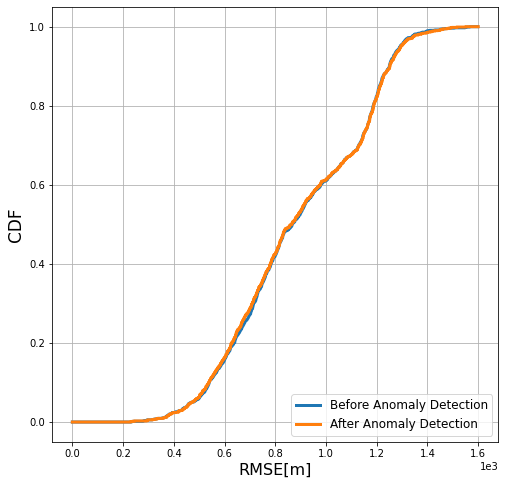

In [978]:
fig, ax1 = plt.subplots(1,1, figsize = (8,8))
plt.grid()
ax1.ticklabel_format(style='sci', scilimits=(-1,2), axis='x')
ax1.plot(Before_bin_edges[:-1], Before_cdf, label = 'Before Anomaly Detection', linewidth=3.0)
ax1.plot(After_bin_edges[:-1], After_cdf, label = 'After Anomaly Detection', linewidth=3.0)
# ax1.hist(Before_sumMSE, bins = 1000, label = 'Localization Error cdf', range=(0, 1.0*1e6), alpha = 0.5, cumulative=True, density=True)
ax1.legend(loc='lower right', prop={'size': 12})
ax1.set_xlabel('RMSE[m]', fontsize=16)
ax1.set_ylabel('CDF', fontsize=17)
# plt.savefig("Log-RMSE.svg")
# plt.savefig(rootpath+'/datas/localizationResult/Log-RMSE{}_{}_{}.svg'.format(div, pick, model))